# Statistics

This notebook is to present and work through my understanding of statistics up to linear regression.

## Estimating parameters via maximum likelihood estimation

Start with parameter estimation.

In [705]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Fitting earthquake data

In [706]:
def load_earthquake_data():
    eq_data = pd.read_csv(filepath_or_buffer="earthquake-data.csv", usecols=[0])

    return eq_data

In [707]:
eq_data = load_earthquake_data()
eq_data

,time
0,2023-12-23T16:38:37.452Z
1,2023-12-23T15:42:07.690Z
2,2023-12-23T15:31:03.763Z
3,2023-12-23T15:07:44.700Z
4,2023-12-23T14:45:45.199Z
...,...
12728,2023-06-23T03:17:22.005Z
12729,2023-06-23T02:30:31.862Z
12730,2023-06-23T02:22:51.027Z
12731,2023-06-23T01:11:46.630Z


In [708]:
eq_data["time"].iat[-1]

'2023-06-23T00:58:07.701Z'

In [709]:
def convert_time_str_to_secs(time_str):
    year = float(time_str[0:4])
    month = float(time_str[5:7])
    day = float(time_str[8:10])
    hour = float(time_str[11:13])
    min = float(time_str[14:16])
    sec = float(time_str[17:19])

    secs_in_min = 60
    secs_in_hour = 60 * 60
    secs_in_day = 24 * 60 * 60
    secs_in_month = 30 * 24 * 60 * 60

    return sec + secs_in_min * min + secs_in_hour * hour + secs_in_day * day + secs_in_month * month

In [710]:
time_float = convert_time_str_to_float(eq_data["time"].iat[-1])
time_float

17542687.0

In [711]:
eq_data["time-secs"] = eq_data["time"].apply(convert_time_str_to_secs)
eq_data["time-secs"] = np.sort( eq_data["time-secs"].to_numpy() )[::-1]
eq_data

,time,time-secs
0,2023-12-23T16:38:37.452Z,33151117.0
1,2023-12-23T15:42:07.690Z,33147727.0
2,2023-12-23T15:31:03.763Z,33147063.0
3,2023-12-23T15:07:44.700Z,33145664.0
4,2023-12-23T14:45:45.199Z,33144345.0
...,...,...
12728,2023-06-23T03:17:22.005Z,17551042.0
12729,2023-06-23T02:30:31.862Z,17548231.0
12730,2023-06-23T02:22:51.027Z,17547771.0
12731,2023-06-23T01:11:46.630Z,17543506.0


In [712]:
intervals = eq_data["time-secs"].iloc[:-1].to_numpy() - eq_data["time-secs"].iloc[1:].to_numpy()

eq_data["time-intervals"] = np.concatenate( ( intervals, np.array( [ intervals.mean() ] ) ) )
eq_data

,time,time-secs,time-intervals
0,2023-12-23T16:38:37.452Z,33151117.0,3390.000000
1,2023-12-23T15:42:07.690Z,33147727.0,664.000000
2,2023-12-23T15:31:03.763Z,33147063.0,1399.000000
3,2023-12-23T15:07:44.700Z,33145664.0,1319.000000
4,2023-12-23T14:45:45.199Z,33144345.0,1259.000000
...,...,...,...
12728,2023-06-23T03:17:22.005Z,17551042.0,2811.000000
12729,2023-06-23T02:30:31.862Z,17548231.0,460.000000
12730,2023-06-23T02:22:51.027Z,17547771.0,4265.000000
12731,2023-06-23T01:11:46.630Z,17543506.0,819.000000


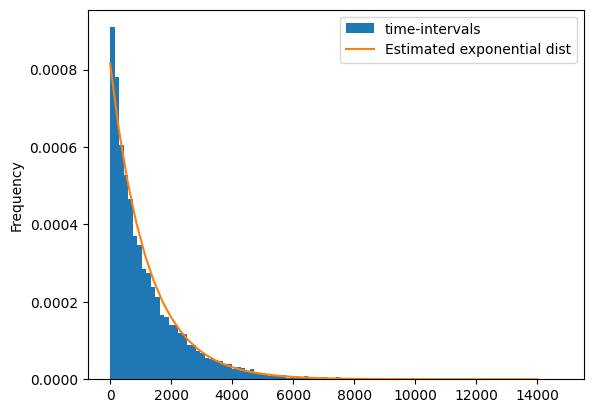

In [713]:
ax = eq_data["time-intervals"].plot.hist(bins=100, density=True)

tbar = np.mean(eq_data["time-intervals"])

t = np.linspace(0, 14000)
p = 1 / tbar * np.exp(-t / tbar)

ax.plot(t, p, label="Estimated exponential dist")

ax.legend()

In [714]:
def compute_log_likelihood(mu, intervals):
    n = len(intervals)
    log_likelihood = -n * np.log(mu) - 1/mu * intervals.sum()

    return log_likelihood

In [715]:
mus = np.concatenate( ( np.linspace(800, tbar), np.linspace(tbar+1,1600) ) )
#mus = np.array([_ for _ in range(800,int(tbar))] + [_ for _ in range(int(tbar)+1,1600)], dtype=np.float64)

log_likelihoods = compute_log_likelihood(mus, eq_data["time-intervals"])

# pick mu that maximises the log likelihood
mu_loglik = mus[np.argmax(log_likelihoods)]

print(f"The mu from the computed MLE is {mu_loglik}, whereas the analytic MLE is {tbar}")

The mu from the computed MLE is 1225.921300659755, whereas the analytic MLE is 1225.921300659755


### Confidence intervals

In [716]:
def CI_contains_mu(Xbar, mu, sigma_bar, n):
    return (Xbar - 1.96 * sigma_bar / np.sqrt(n) < mu) & (mu < Xbar + 1.96 * sigma_bar / np.sqrt(n))

In [717]:
def gaussian(x, mu, sigma):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sigma) * np.exp(-np.power((x - mu) / sigma, 2.0) / 2)
    )

In [718]:
rng = np.random.default_rng()

n = 1000
m = 10000

95.12% of the CIs contain the normal distribution's mu.


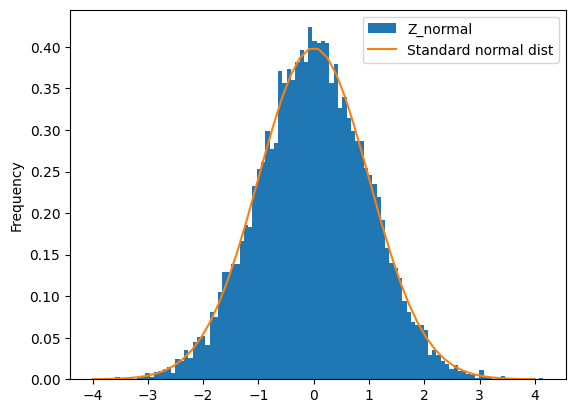

In [719]:
mu_normal = 1
sigma_normal = 2

samples = pd.DataFrame(
    data=np.array([rng.normal(loc=mu_normal, scale=sigma_normal, size=n).mean() for _ in range(m)]),
    columns=['Xbar_normal']
)

samples['Z_normal'] = (samples['Xbar_normal'] - mu_normal) / ( sigma_normal / np.sqrt(n) )

ax = samples['Z_normal'].plot.hist(bins=100, density=True)
x = np.linspace(-4,4)
p = gaussian(x, 0, 1)
ax.plot(x, p, label='Standard normal dist')
ax.legend()

samples['contains_normal'] = CI_contains_mu(samples['Xbar_normal'], mu_normal, sigma_normal, n)

CI_containing_mu = samples['contains_normal'].sum() / m * 100

print(f"{CI_containing_mu}% of the CIs contain the normal distribution's mu.")

#### CIs with central limit theorem: exponential distribution

95.0% of the CIs contain the exponential distribution's mu.


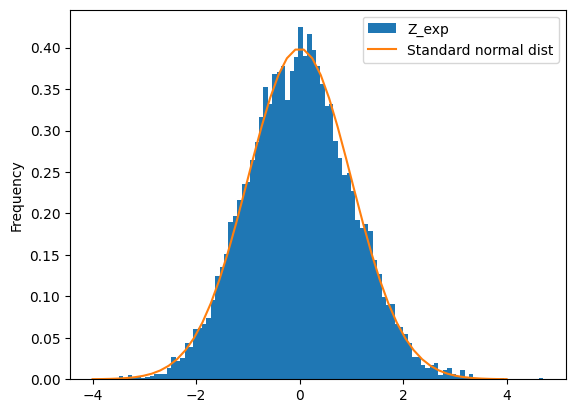

In [720]:
mu_exp = 1225

samples['Xbar_exp'] = np.array([rng.exponential(scale=mu_exp, size=n).mean() for _ in range(m)])
samples['Z_exp']    = (samples['Xbar_exp'] - mu_exp) / ( mu_exp / np.sqrt(n) )

ax = samples['Z_exp'].plot.hist(bins=100, density=True)
ax.plot(x, p, label='Standard normal dist')
ax.legend()

samples['contains_exp'] = CI_contains_mu(samples['Xbar_exp'], mu_exp, samples['Xbar_exp'], n)

CI_containing_mu = samples['contains_exp'].sum() / m * 100

print(f"{CI_containing_mu}% of the CIs contain the exponential distribution's mu.")

#### CIs with central limit theorem: coin flips

94.48% of the CIs contain the exponential distribution's mu.


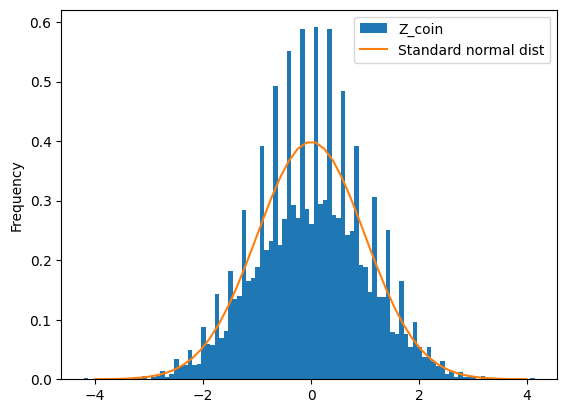

In [721]:
p_coin = 0.5
sigma_coin = np.sqrt( p_coin * (1 - p_coin) )

samples['Xbar_coin']     = np.array([rng.binomial(n=1, p=p_coin, size=n).mean() for _ in range(m)])
samples['sigmabar_coin'] = np.sqrt( samples['Xbar_coin'] * (1 - samples['Xbar_coin']) ) 
samples['Z_coin']        = (samples['Xbar_coin'] - p_coin) / ( samples['sigmabar_coin'] / np.sqrt(n) )

ax = samples['Z_coin'].plot.hist(bins=100, density=True)
ax.plot(x, p, label='Standard normal dist')
ax.legend()

samples['contains_coin'] = CI_contains_mu(samples['Xbar_coin'], p_coin, samples['sigmabar_coin'], n)

CI_containing_mu = samples['contains_coin'].sum() / m * 100

print(f"{CI_containing_mu}% of the CIs contain the exponential distribution's mu.")

## ISLP Chapter 2

### Exercise 8

In [722]:
college = pd.read_csv('college.csv')
college

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


In [723]:
college.rename(columns={'Unnamed: 0' : 'College'}, inplace=True)
college.set_index('College')

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
College,,,,,,,,,,,,,,,,,,
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49


<Axes: >

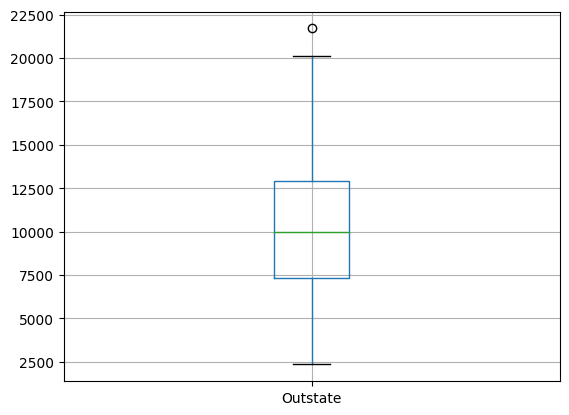

In [724]:
college.boxplot(column=['Outstate'])

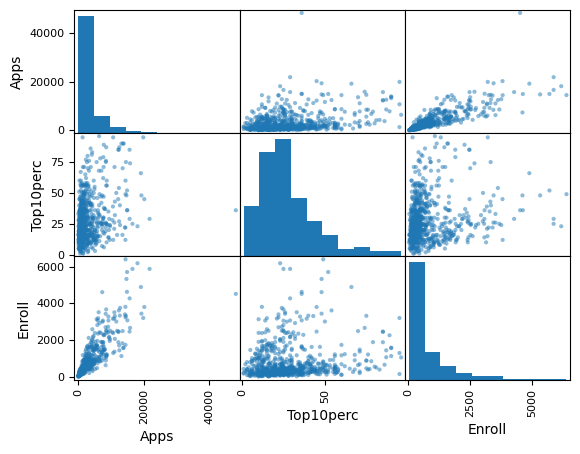

In [725]:
pd.plotting.scatter_matrix(college[['Apps', 'Top10perc', 'Enroll']]);

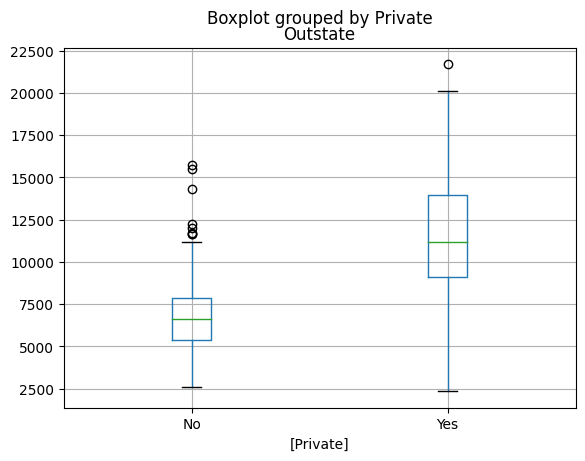

In [726]:
college.boxplot(column=['Outstate'], by=['Private']);

In [727]:
college['Elite'] = pd.cut(x=college['Top10perc'], bins=[0, 50, 100], labels=['No', 'Yes'])
college

,College,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,No
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,No
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,No
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,Yes
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40,No
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83,No
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49,No
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99,Yes


In [728]:
college['Elite'].value_counts()

Elite
No     699
Yes     78
Name: count, dtype: int64

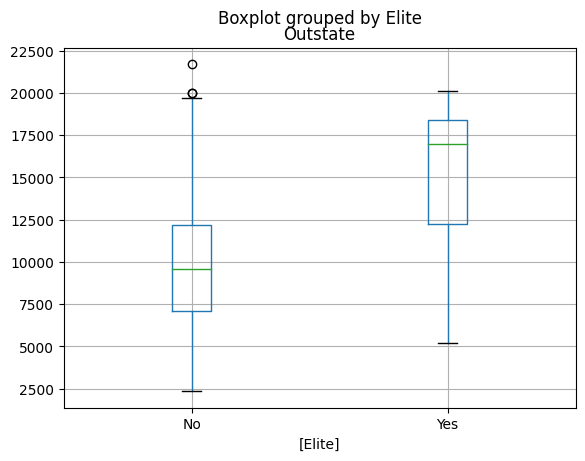

In [729]:
college.boxplot(column=['Outstate'], by=['Elite']);

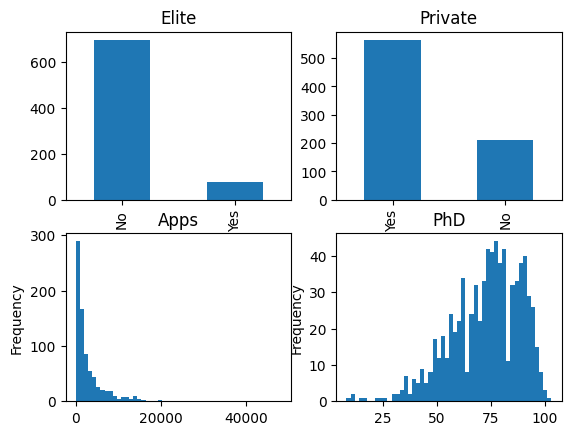

In [746]:
fig, axs = plt.subplots(nrows=2, ncols=2)

college['Elite'].value_counts().plot.bar(ax=axs[0,0], title='Elite')
college['Private'].value_counts().plot.bar(ax=axs[0,1], title='Private')
college['Apps'].plot.hist(bins=50, ax=axs[1,0], title='Apps')
college['PhD'].plot.hist(bins=50, ax=axs[1,1], title='PhD');

### Exercise 9

In [803]:
auto = pd.read_csv('Auto.csv')
auto.set_index('name', inplace=True)
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


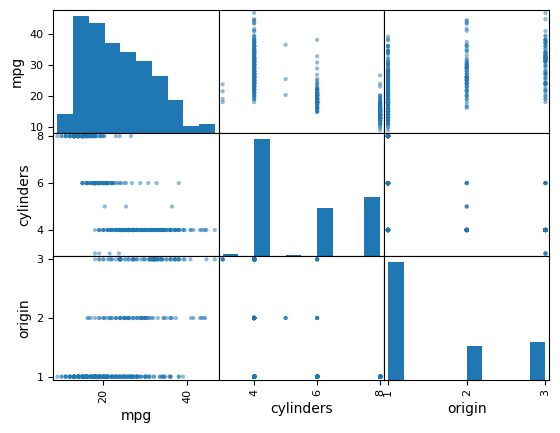

In [804]:
pd.plotting.scatter_matrix(auto[['mpg', 'cylinders', 'origin']]);

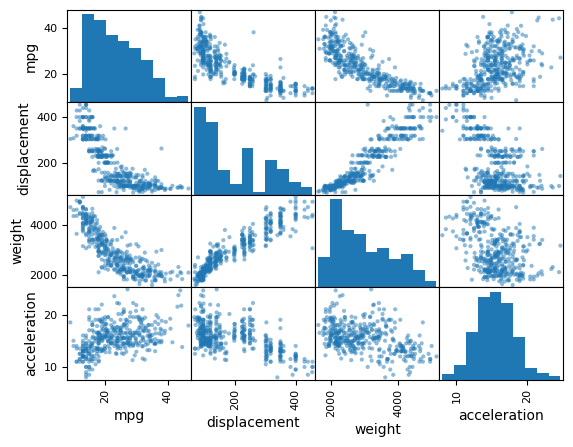

In [805]:
pd.plotting.scatter_matrix(auto[['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']]);

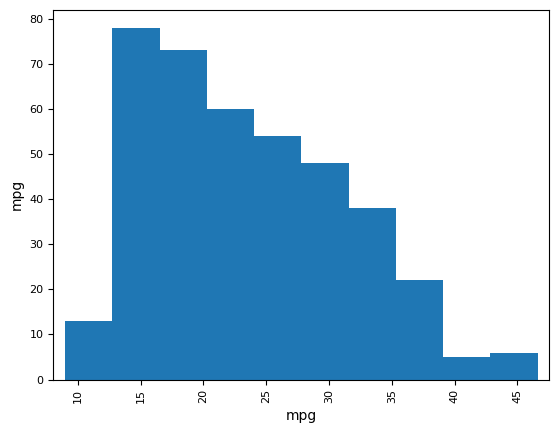

In [806]:
pd.plotting.scatter_matrix(auto[['mpg', 'horsepower']]);

In [807]:
with pd.option_context('display.max_rows', 10):
    display(auto['horsepower'])

name
chevrolet chevelle malibu    130
buick skylark 320            165
plymouth satellite           150
amc rebel sst                150
ford torino                  140
                            ... 
ford mustang gl               86
vw pickup                     52
dodge rampage                 84
ford ranger                   79
chevy s-10                    82
Name: horsepower, Length: 397, dtype: object

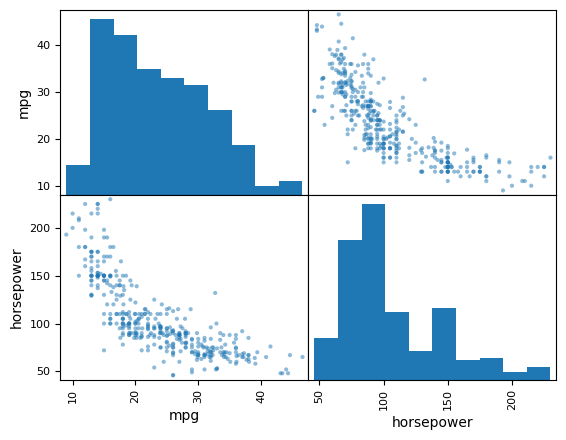

In [809]:
auto.drop(auto[auto['horsepower'] == '?'].index, inplace=True)
auto['horsepower'] = auto['horsepower'].astype(float)
pd.plotting.scatter_matrix(auto[['mpg', 'horsepower']]);

### ISLP Chapter 3

#### Exercise 8

In [847]:
auto = pd.read_csv('Auto.csv')
auto.drop(auto[auto['horsepower'] == '?'].index, inplace=True)
auto['horsepower'] = auto['horsepower'].astype(float)
auto.set_index('name', inplace=True)
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86.0,2790,15.6,82,1
vw pickup,44.0,4,97.0,52.0,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84.0,2295,11.6,82,1


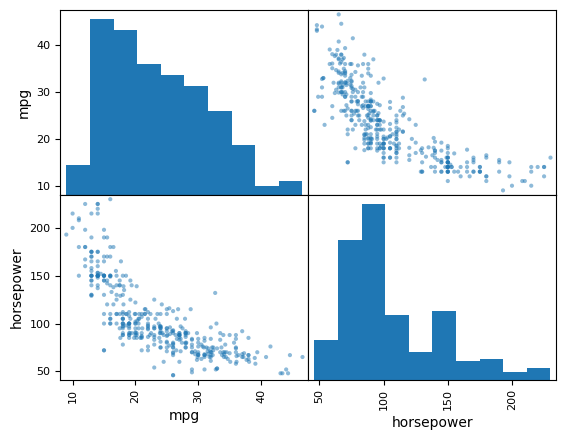

In [850]:
pd.plotting.scatter_matrix(auto[['mpg', 'horsepower']]);

In [863]:
def compute_beta(X, y):
    X = np.array([np.ones(shape=(X.shape[0])), X]).transpose()
    
    beta_hat = np.matmul(
        np.linalg.inv( np.matmul(np.transpose(X), X) ),
        np.matmul(np.transpose(X), y)
    )
    
    return beta_hat[0], beta_hat[1]

In [880]:
def compute_residuals(X, y, intercept, slope):
    yhat = intercept + slope * X

    e = y - yhat

    return e

In [916]:
def compute_std_errs(X, sigma):
    n = X.shape[0]
    Xbar = X.mean()
    SD_intercept = np.sqrt( sigma ** 2 * (1 / n + Xbar ** 2 / ( (X - Xbar) ** 2 ).sum() ) )
    SD_slope     = np.sqrt( sigma ** 2 / ( (X - Xbar) ** 2 ).sum() )
    return SD_intercept, SD_slope

In [881]:
intercept, slope = compute_beta(auto['horsepower'], auto['mpg'])

In [882]:
intercept

39.93586102117048

In [883]:
slope

-0.15784473335365365

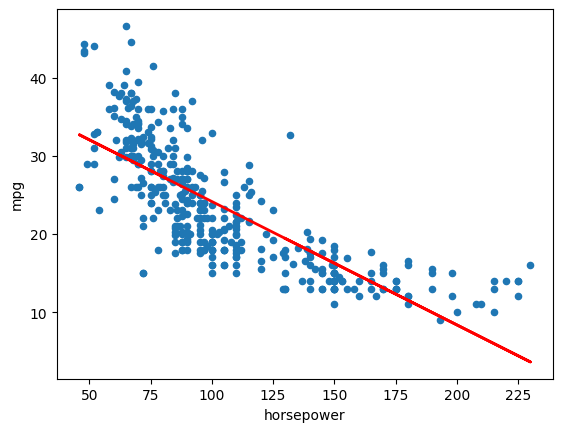

In [940]:
yhat = intercept + slope * auto['horsepower']

ax = auto.plot(kind='scatter', x='horsepower', y='mpg')
ax.plot(auto['horsepower'], yhat, linewidth=2, color='r');

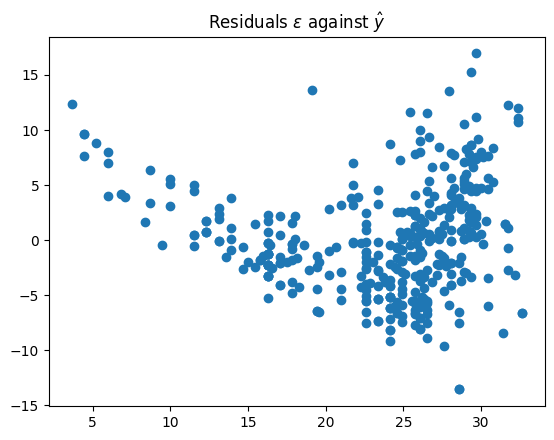

In [960]:
e = compute_residuals(auto['horsepower'], auto['mpg'], intercept, slope)

fig, ax = plt.subplots()

ax.scatter(yhat, e)
ax.set_title('Residuals $\epsilon$ against $\hat{y}$');

In [957]:
# like computing biased sample variance for a pdf, i.e. s = \Sigma (xi - xbar) / n
# but collecting over all x,y pairs: hence assumption that ei are uncorrelated and iid
RSS = (e ** 2).sum()
RSS

9385.915871932419

In [958]:
# number of samples
n = len(e)

# really the unbiased sample std dev for a simple lin reg model
RSE = np.sqrt( RSS / (n - 2) )
RSE

4.90575691954594

In [928]:
SD_intercept, SD_slope = compute_std_errs(auto['horsepower'], RSE)
SD_intercept

0.7174986555545264

In [929]:
SD_slope

0.006445500517685034

In [920]:
# t = (Xbar - mu) / (sigmahat / sqrt(n))
# Xbar is sample mean and should be normally distributed
# sigmahat is sample std dev
# sample variance should be chi^2 distributed with n - p - 1 degrees of freedom
# numerator and denominator should be independent
# hypothesis test by assuming mu = 0 and checking the t score and p-value:
# probability of t score being far from 0 is small;
# if indeed far from zero, can't be due to chance and p-value would be small
# need to understand why this is valid: t = Xbar / SE(Xbar)
t_intercept = intercept / SD_intercept
t_slope     = slope     / SD_slope

In [921]:
t_intercept

55.65984090981415

In [922]:
t_slope

-24.489135160343633

In [959]:
# total sum of squares, i.e. RSS using mean model
TSS = ( ( auto['mpg'] - auto['mpg'].mean() ) ** 2 ).sum()

# R-squared, amount of variance explained by linear model cf mean model
# closer to 1 means RSS is small means more variance is explained means better linear model
R2 = (TSS - RSS) / TSS
R2

0.605948257889435

In [963]:
# F statistic = ((TSS - RSS) / p) / (RSS / (n - p - 1)); here p = 0
# if null hypothesis true, E[(TSS - RSS) / p] = sigma
# E[RSS / (n - p - 1)] = sigma, thus F statistic = 1, so large values make us reject null hypothesis
F = ((TSS - RSS) / 1) / (RSS / (n - 1 - 1))
F

599.7177409015787

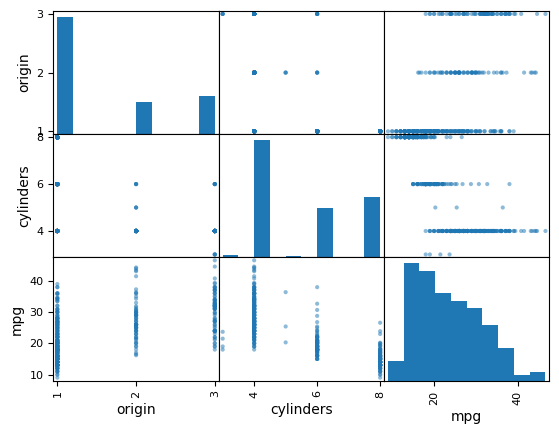

In [967]:
pd.plotting.scatter_matrix(auto[['origin', 'cylinders', 'mpg']]);

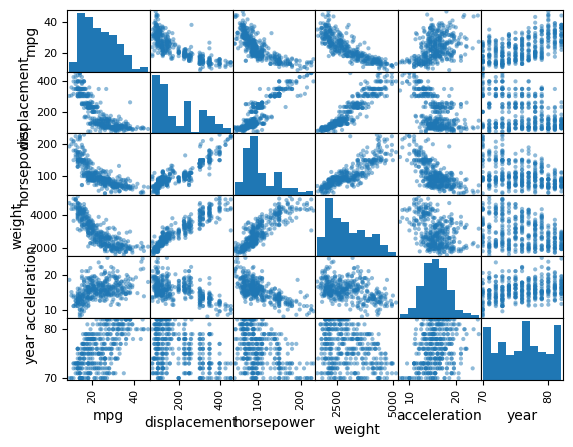

In [970]:
continuous_vars = auto.columns.drop(['cylinders', 'origin'])
pd.plotting.scatter_matrix(auto[continuous_vars]);

In [974]:
auto[continuous_vars].corr()

,mpg,displacement,horsepower,weight,acceleration,year
mpg,1.000000,-0.805127,-0.778427,-0.832244,0.423329,0.580541
displacement,-0.805127,1.000000,0.897257,0.932994,-0.543800,-0.369855
horsepower,-0.778427,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.832244,0.932994,0.864538,1.000000,-0.416839,-0.309120
acceleration,0.423329,-0.543800,-0.689196,-0.416839,1.000000,0.290316
year,0.580541,-0.369855,-0.416361,-0.309120,0.290316,1.000000
